In [1]:
import pandas as pd
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time

In [2]:
import scipy.io
import pandas as pd
import os

# Function to load and process a single .mat file
def load_mat_file(file_path):
    mat_data = scipy.io.loadmat(file_path)
    
    # Extract relevant information from the 'o' field
    o = mat_data['o'][0, 0]
    
    # Extract EEG data and marker
    data = o['data']
    marker = o['marker']
    
    # Extract other relevant information
    nS = o['nS'][0, 0]
    sampFreq = o['sampFreq'][0, 0]
    
    # Create a dataframe
    columns = ['EEG_' + str(i) for i in range(1, 23)]  # Naming the columns
    df = pd.DataFrame(data, columns=columns)
    
    # Add marker column
    df['Marker'] = marker
    
     # Add sampling frequency column
    df['Sampling Frequency'] = sampFreq

    # Add time column 
    df['Time'] = np.arange(0, nS) / sampFreq
    
    return df

# Function to create separate dataframes for each paradigm
def create_paradigm_datasets(data_directory):
    paradigm_datasets = {}
    
    # Iterate through all files in the directory except ones with HFREQ in their name
    for file in os.listdir(data_directory) :
        if 'HFREQ' not in file and file.endswith(".mat"):
            file_path = os.path.join(data_directory, file)
            
            # Extract paradigm name from the file name
            paradigm = file.split('-')[0]
            
            # Load and process the file
            df = load_mat_file(file_path)
            
            # Add the dataframe to the corresponding paradigm dataset
            if paradigm not in paradigm_datasets:
                paradigm_datasets[paradigm] = df
            else:
                paradigm_datasets[paradigm] = pd.concat([paradigm_datasets[paradigm], df], ignore_index=True)
    
    return paradigm_datasets

# Specify the directory containing the .mat files
data_directory = 'data/'

# Create separate datasets for each paradigm
paradigm_datasets = create_paradigm_datasets(data_directory)

# save the datasets
for paradigm, df in paradigm_datasets.items():
    df.to_csv(paradigm + '.csv', index=False)

# save the overall dataset
overall_df = pd.concat(paradigm_datasets.values(), ignore_index=True)
overall_df.to_csv('overall.csv', index=False)


5F
5F
5F
5F
5F
5F
5F
5F
5F
5F
5F
5F
5F
5F
5F
5F
5F
5F
5F
CLA
CLA
CLA
CLA
CLA
CLA
CLA
CLA
CLA
CLA
CLA
CLA
CLA
CLA
CLA
CLA
CLA
FREEFORM
FREEFORM
FREEFORM
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
HaLT
NoMT
NoMT
NoMT
NoMT
NoMT
NoMT
NoMT


In [ ]:
# if "HFREQ" is in the file name, delete it
for file in os.listdir(data_directory) :
    if 'HFREQ' in file:
        os.remove(os.path.join(data_directory, file))

In [18]:
matlabdata

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Apr 05 19:18:15 2016',
 '__version__': '1.0',
 '__globals__': [],
 'o': array([[(array(['201604051923.D091BB44'], dtype='<U21'), array(['NK-data import (auto)'], dtype='<U21'), array([[200]], dtype=uint8), array([[718600]]), array([[0],
                [0],
                [0],
                ...,
                [0],
                [0],
                [0]], dtype=uint8), array([[ -0.  ,  -0.  ,  -0.  , ...,  -0.  ,  -0.  ,  -0.  ],
                [ -0.  ,  -0.  ,  -0.  , ...,  -0.  ,  -0.  ,  -0.  ],
                [ -0.  ,  -0.  ,  -0.  , ...,  -0.  ,  -0.  ,  -0.  ],
                ...,
                [156.28,  41.49,   0.63, ...,  -3.25,  -8.5 ,  -1.17],
                [163.56,  45.57,   2.93, ...,  -3.58,  -8.92,  -1.25],
                [144.27,  32.3 ,   2.52, ...,  -1.98,  -9.56,  -0.89]]), array([[array(['Fp1'], dtype='<U3')],
                [array(['Fp2'], dtype='<U3')],
                [array(['F

Creating RawArray with float64 data, n_channels=22, n_times=718600
    Range : 0 ... 718599 =      0.000 ...  3592.995 secs
Ready.


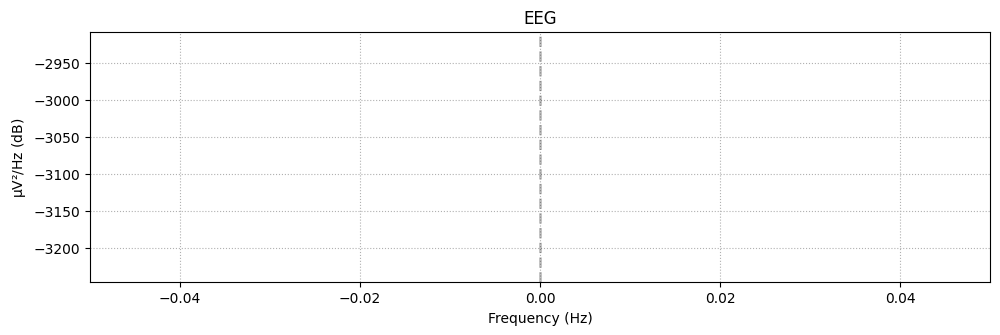

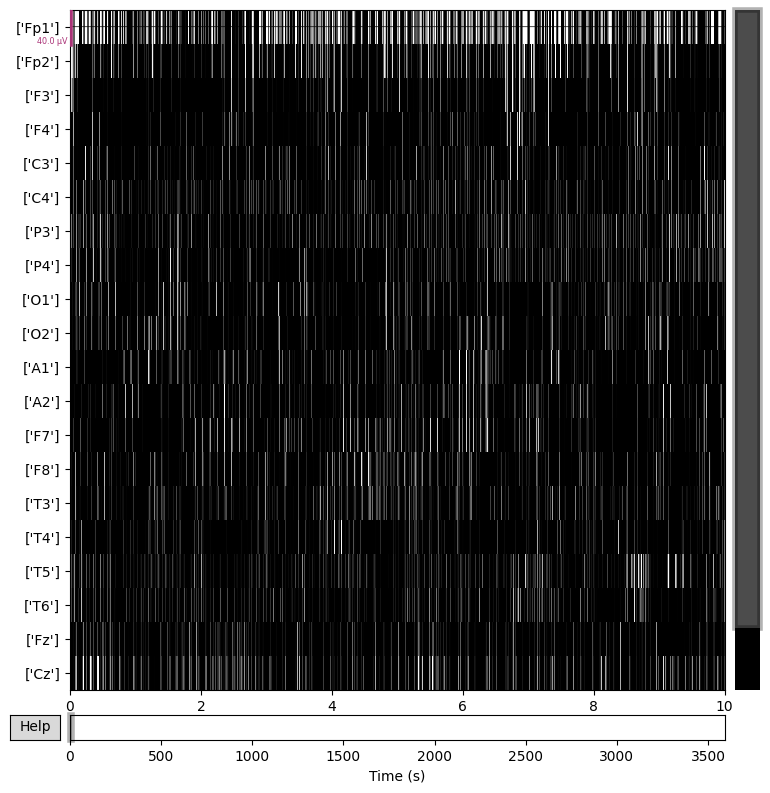

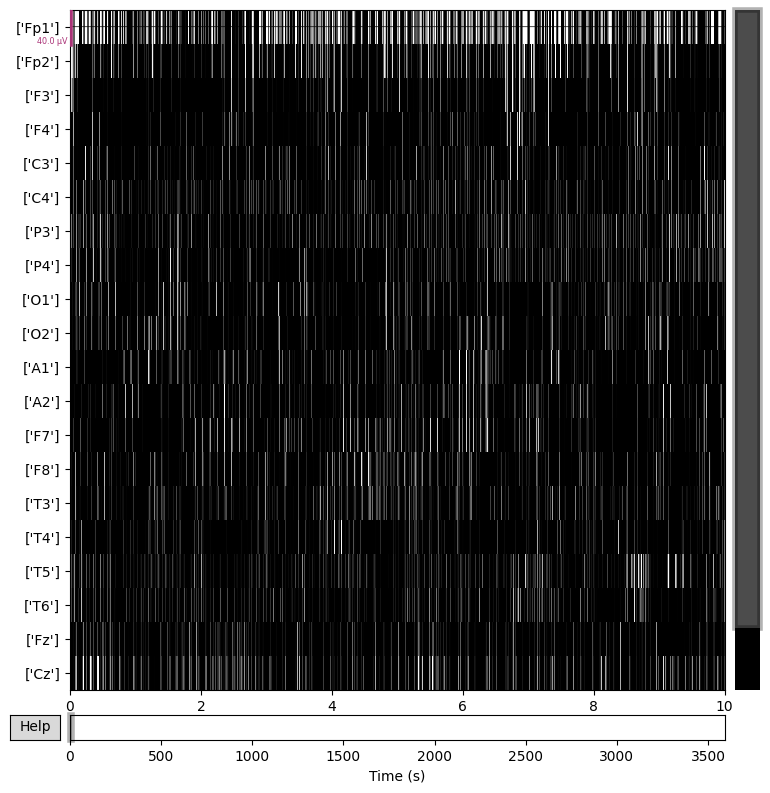

In [89]:
import mne

# Load the .mat file
file = 'data/5F-SubjectA-160405-5St-SGLHand.mat'
matlabdata = scipy.io.loadmat(file)
o = matlabdata['o'][0, 0]

# Extract relevant information from the loaded data
samp_freq = o['sampFreq'][0, 0]
channel_names = [name[0] for name in o['chnames']]
data_type = np.float64  # Assuming the data is stored as float64

# Convert channel names to strings
channel_names = [str(name) for name in channel_names]

# Extract EEG data
eeg_data = matlabdata['o'][0][0]['data']

# Reshape the data to (n_channels, n_samples)
eeg_data = eeg_data.reshape(len(channel_names), -1)

# Create info dictionary
info = mne.create_info(ch_names=channel_names, sfreq=samp_freq, ch_types='eeg')

# Create RawArray
raw = mne.io.RawArray(eeg_data, info)

# Extract 'marker' information
marker_data = o['marker'][0]

# Add 'marker' information to raw data as events
events = np.column_stack((np.arange(len(marker_data)), np.zeros(len(marker_data), dtype=int), marker_data))

# Add channel types
raw.set_channel_types({channel: 'eeg' for channel in channel_names})

# plot
raw.plot()


In [84]:
matlabdata['o'][0][0]['data']

array([[ -0.  ,  -0.  ,  -0.  , ...,  -0.  ,  -0.  ,  -0.  ],
       [ -0.  ,  -0.  ,  -0.  , ...,  -0.  ,  -0.  ,  -0.  ],
       [ -0.  ,  -0.  ,  -0.  , ...,  -0.  ,  -0.  ,  -0.  ],
       ...,
       [156.28,  41.49,   0.63, ...,  -3.25,  -8.5 ,  -1.17],
       [163.56,  45.57,   2.93, ...,  -3.58,  -8.92,  -1.25],
       [144.27,  32.3 ,   2.52, ...,  -1.98,  -9.56,  -0.89]])